# Подключение библиотек

In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import seaborn as sns
import os
import time

from time import time

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

from ipywidgets import IntProgress
from IPython.display import display

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel


# Подбор переменных, выбор папки и файла

In [2]:
# Указываем путь к директории
#directory = "D:\\МАРЬЯМ 13.03.2025\\4 часа"
#directory = "C:\Synology\Alex\dev\\trackCalc\\test"
directory = "D:\\POBEDA\\Для Алексея 10.04.25"

inv = False
th = 2
mass_level = 100
mem = 0
max_dist = 20
diam = 19

filt_len = 2 #длина траекторий для фильтрации, 50 - это 4 секунды хотя бы
base_n = 50 #база для усрднения фона
threshold_bc = 4 #уровень шума для вычитания фона

k_to_µm = 0.16 #надо посчитать количество микрон (в ширину) на всей картинке,
               #а потом разделить на количество пикселей в ширину. Потом просто умножать скорости на это.
k_to_sec = 25 # тоже надо умножать скорости на это для перевода из мкм/кадр в мкм/сек. Это просто сколько кадров в секунду

0 К-1840-1час.avi
1 К-1840-2 часа.avi
2 ФТ-1840-1 час.avi
3 ФТ-1840-2часа.avi
введите номер файла (нумерация с нуля!)


 0


К-1840-1час.avi 863


Frame([[ 16,  16,  16, ...,  16,  16,  16],
       [ 16,  88,  88, ...,  16,  16,  16],
       [ 16,  84,  92, ...,  16,  16,  16],
       ...,
       [ 16, 179, 179, ..., 167, 129,  16],
       [ 16, 175, 180, ..., 167,  99,  16],
       [ 16,  16,  16, ...,  16,  16,  16]], dtype=uint8)
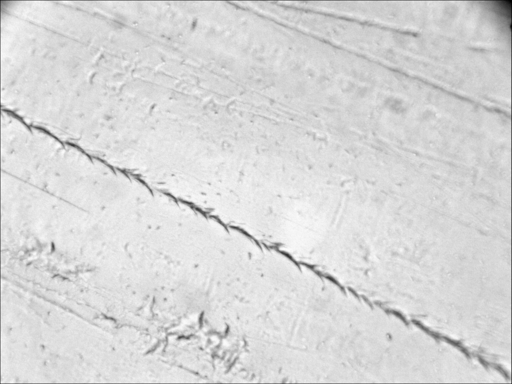

In [3]:
# Создаем пустые списки с данными по гистограммам
files = []
trj_list = []
hist_list = []
title_list = []
label_list = []
 
# Выводим список файлов
files += os.listdir(directory)
i = 0
for name in files:
    if name.split('.')[-1] == 'avi':
        title_list.append(name)
        print(i, name)
        i+=1
label_list = title_list

#выбираем файл и загружаем его
print('введите номер файла (нумерация с нуля!)')
file_name = title_list[int(input())]

frames = gray(pims.Video(directory + '\\' + file_name))
title = file_name
print(file_name, len(frames))
frames[10]

# Вычитание фона

calculate background
106.67135620117188 sec
delete background (dark feathcers)
181.17472791671753 sec


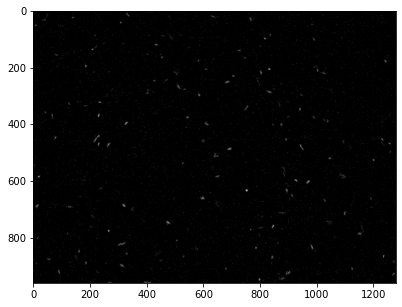

In [4]:

print('calculate background')
t1 = time()

_b = np.cumsum(frames, 0)
_b = (_b[base_n:] - _b[:-base_n]) / base_n
before = base_n // 2
after = base_n - before
_b = np.pad(_b, [[before, after], [0, 0], [0, 0]], mode='edge')

t2 = time()
print(t2 - t1,"sec")


print('delete background (dark feathcers)')
t1 = time()

_a = _b - np.asarray(frames)
res = np.where(_a < threshold_bc, 0, _a)

t2 = time()
t2 - t1
print(t2 - t1,"sec")

fig, ax = plt.subplots()
ax.imshow(res[100])
plt.show()

# *Исследуем кусочек одного кадра (оценка расстояния dist и тд)

len: 863


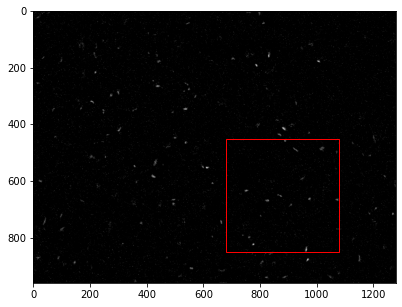

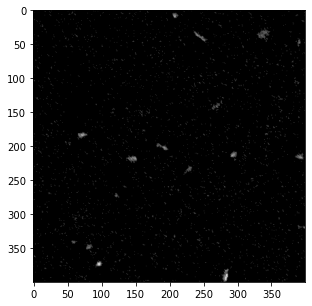

In [5]:
i = 203

x = 680
y = 450
dx = 400
dy = 400

#res[i] = bc_list[i] - frames[i]
#res[i][bc_list[i] - frames[i] < 2] = 0
#res[i][705][550] = 40


one_frame = res[i]
#one_frame = frames[i]
#one_frame = bc_list[i]



fig, ax = plt.subplots()
ax.imshow(one_frame)
rect = patches.Rectangle((x, y), dx, dy, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

print('len:', len(frames))
plt.show()

one_frame = one_frame[y:y+dy,x:x+dx]
fig, ax = plt.subplots()
ax.imshow(one_frame)
plt.show()

In [23]:
# Еще раз скопировать наверх после подбора!!!!!!!
inv = False
th = 0
mem = 0

mass_level = 100
max_dist = 27
diam = 21

Before: 100
After: 13


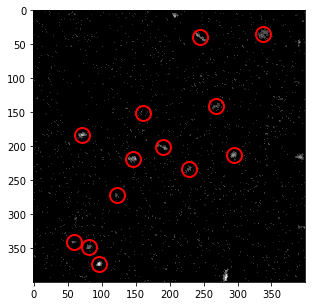

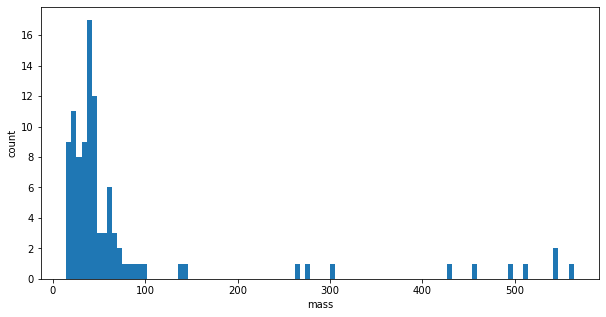

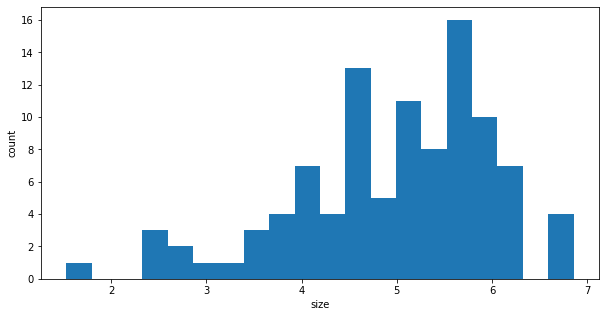

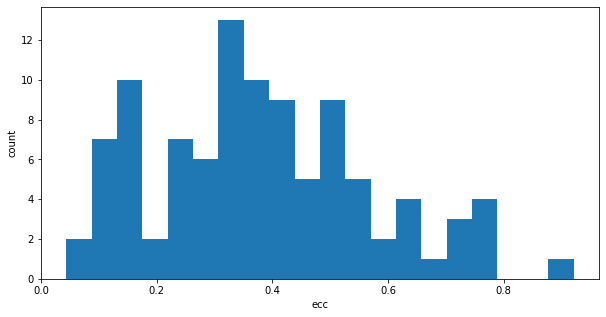

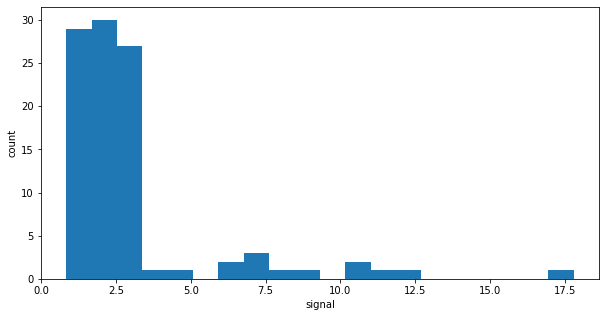

In [16]:
#рассматриваем один кадр - и подбираем массу(!!!), диаметр, уровень шума
i=100
#one_frame = res[i]
#one_frame = frames[i]

f = tp.locate(one_frame, diameter = diam, threshold = th, invert=inv)
new_f = f[f['mass'] > mass_level] # чем ярче, тем больше этот параметр. Нам подходят БОЛЬШЕ какого то значения
#new_f = f[f['signal'] > 10] # чем ярче, тем больше этот параметр. Нам подходят БОЛЬШЕ какого то значения
#new_f = f[f['size'] > 4]
#new_f = f[f['ecc'] > 0.7]

print('Before: {0}'.format(len(f)))
print('After: {0}'.format(len(new_f)))
tp.annotate(new_f, one_frame)

fig, ax = plt.subplots()
ax.hist(f['mass'], bins=100)
ax.set(xlabel='mass', ylabel='count');

fig, ax = plt.subplots()
ax.hist(f['size'], bins=20)
ax.set(xlabel='size', ylabel='count');

fig, ax = plt.subplots()
ax.hist(f['ecc'], bins=20)
ax.set(xlabel='ecc', ylabel='count');

fig, ax = plt.subplots()
ax.hist(f['signal'], bins=20)
ax.set(xlabel='signal', ylabel='count');

In [17]:
#находим фичи на всех кадрах по подобранным параметрам
t1 = time()

f = tp.batch(res, diameter = diam, threshold = th, invert=inv, processes=1)
new_f = f[f['mass'] > mass_level]

t2 = time()
t2 - t1
print(t2 - t1,"sec")

Frame 862: 897 features
136.47129797935486 sec


# Подбор дистанции для линковки

len: 863


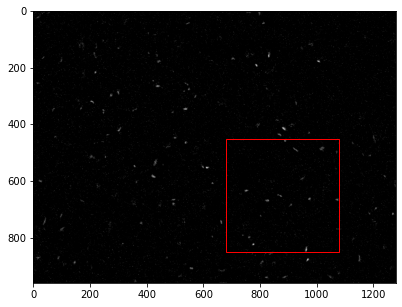

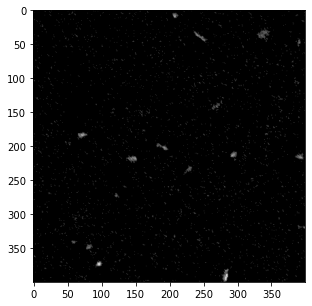

In [18]:
# подбор дистанции по кусочкам видео и нескольким кадрам (выбрать кусочек с быстрой)
i = 203

x = 680
y = 450
dx = 400
dy = 400

di = 10

one_frame = res[i]
#one_frame = frames[i]


fig, ax = plt.subplots()
ax.imshow(one_frame)
rect = patches.Rectangle((x, y), dx, dy, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

print('len:', len(frames))
plt.show()

one_frame = res[i, y:y+dy, x:x+dx]
fig, ax = plt.subplots()
ax.imshow(one_frame)
plt.show()

Frame 9: 109 features


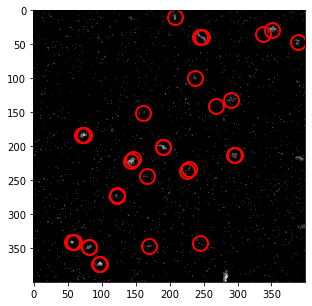

<AxesSubplot:>

In [19]:
# подбор дистанции по кусочкам видео и нескольким кадрам (найти фичи и пр)
_res = res[i:i+di, y:y+dy, x:x+dx] 
_f = tp.batch(_res, diameter = diam, threshold = th, invert=inv, processes=1)

_n = 1
_ff = _f[(_f['mass'] > mass_level) & ((_f['frame'] >= 0) & (_f['frame'] <= _n))]
tp.annotate(_ff, _res[1])

Frame 862: 182 trajectories present.
8094


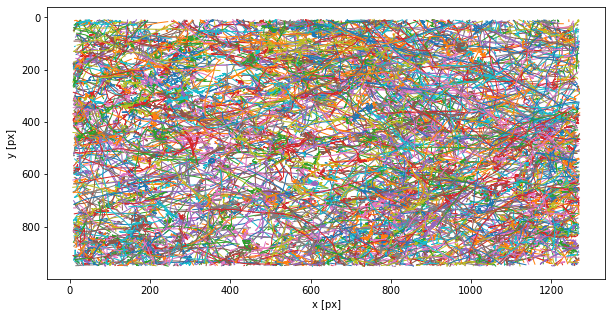

dist = 5, uniq_trj = 10696, avr = 8.136032161555722
dist = 10, uniq_trj = 9459, avr = 10.09197589597209
dist = 15, uniq_trj = 9892, avr = 10.294783663566518
dist = 20, uniq_trj = 10056, avr = 10.85849244232299
dist = 25, uniq_trj = 9116, avr = 12.406208863536639
dist = 30, uniq_trj = 8473, avr = 13.447303198394902
dist = 35, uniq_trj = 8240, avr = 13.858252427184466
dist = 40, uniq_trj = 8094, avr = 14.131084754138868
dist = 45 ERROR


<Figure size 720x360 with 0 Axes>

In [20]:
# подбор дистанции по максимально возможной для этих фич
temp = []
for max_dist in range(5,100,5):
    #Пытаемся выполнить линковку по подобранным параметрам. Подбираем еще раз массу, дистанцию и память
    try:
        new_f = f[f['mass'] > mass_level]
        t = tp.link(new_f, max_dist, memory=mem)

        #рисуем траектории
        filt_len = 2
        t1 = tp.filter_stubs(t, filt_len)
        last_d = max_dist
        data = t1.apply(lambda x: x.value_counts().to_dict())['particle'].values()
        n_uniq = t1['particle'].nunique()
        aver_len = sum(data)/n_uniq
        temp.append("dist = " + str(max_dist) + ", uniq_trj = " + str(t1['particle'].nunique()) + ", avr = " + str(aver_len))
    except:
        temp.append("dist = " + str(max_dist) + " ERROR")
        break
    
t = tp.link(new_f, last_d, memory=mem)
filt_len = 2
t1 = tp.filter_stubs(t, filt_len)
print(t1['particle'].nunique())
tp.plot_traj(t1);
plt.figure()

for s in temp:
    print(s)

# *Распределение траекторий по длительности

Frame 862: 182 trajectories present.


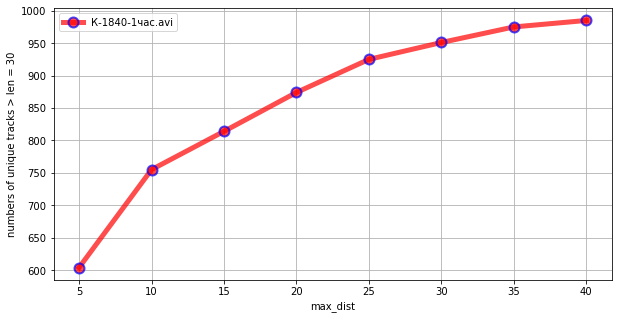

In [22]:
# график как падает количество уникальных при увеличении фильтрации
filt_len = 30 



data_y = []
data_x = []
for max_dist in range(5, 45, 5):
    t = tp.link(new_f, max_dist, memory=mem)
    t1 = tp.filter_stubs(t, filt_len)
    data_y.append(t1['particle'].nunique())
    data_x.append(max_dist)
    

plt.plot(data_x, data_y, 'o-r', label = file_name, alpha=0.7, lw=5, mec='b', mew=2, ms=10)
plt.legend()
plt.ylabel('numbers of unique tracks > len = 30')
plt.xlabel('max_dist')
plt.grid(True)

In [ ]:

plt.plot(data_x, data_y, 'o-r', label = file_name, alpha=0.7, lw=5, mec='b', mew=2, ms=10)
plt.legend()
plt.ylabel('numbers of unique tracks > len = 30')
plt.xlabel('max_dist')
plt.grid(True)

Frame 874: 576 trajectories present.


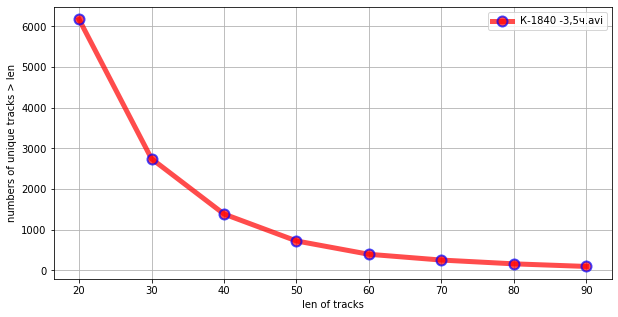

In [18]:
# график как падает количество уникальных при увеличении фильтрации
max_dist = 27 
t = tp.link(new_f, max_dist, memory=mem)


data_y = []
data_x = []
for filt_len in range(20, 100, 10):
    t1 = tp.filter_stubs(t, filt_len)
    data_y.append(t1['particle'].nunique())
    data_x.append(filt_len)
    

plt.plot(data_x, data_y, 'o-r', label = file_name, alpha=0.7, lw=5, mec='b', mew=2, ms=10)
plt.legend()
plt.ylabel('numbers of unique tracks > len')
plt.xlabel('len of tracks')
plt.grid(True)

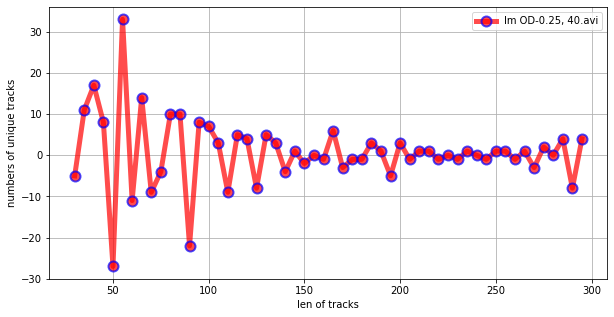

In [68]:
# график распределения количества длительностей траекторий. Сколько длинных, а сколько - коротких траекторий.
_s = 0
for i in range(len(data_y) - 1):
    data_y[i] -= data_y[i+1]

plt.plot(data_x[5:], data_y[5:], 'o-r', label = file_name, alpha=0.7, lw=5, mec='b', mew=2, ms=10)
plt.legend()
plt.ylabel('numbers of unique tracks')
plt.xlabel('len of tracks')
plt.grid(True)

In [8]:
filt_len = 30
max_dist = 20

#new_f = f[f['ecc'] > 0]
new_f = f[f['mass'] > mass_level]
t = tp.link(new_f, max_dist, memory=mem)

t1 = tp.filter_stubs(t, filt_len)
print("trj longer then"+str(filt_len))
print(t1['particle'].nunique())
tp.plot_traj(t1);
plt.figure()

KeyError: 'frame'

# Строим гистограмму 

Frame 875: 1107 trajectories present.
len more then  90  =  937 max_dist = 20


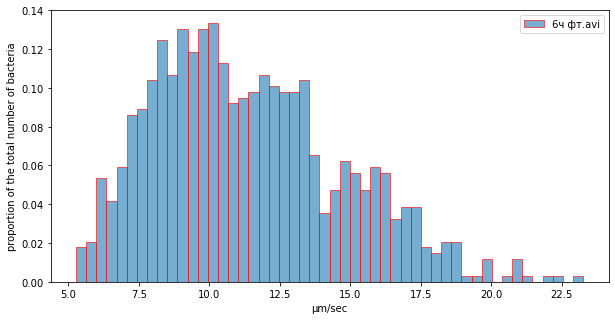

In [87]:
#вычисляем данные для гистограммы
max_dist = 20
t = tp.link(new_f, max_dist, memory=mem)
filt_len = 90


speeds = []
#d = tp.compute_drift(t)
#t = tp.subtract_drift(t.copy(), d)

#рассчет средней скорости у частиц

t1 = tp.filter_stubs(t, filt_len)
print('len more then ', filt_len, ' = ', t1['particle'].nunique(),"max_dist =", max_dist)
for i in t1['particle'].unique():
    speed = t1[t1['particle'] == i]
    speed = speed.diff()
    speed['v'] = ((speed['x']*speed['x'] + speed['y']*speed['y'])**(0.5)/speed['frame'])*k_to_µm*k_to_sec
    v = speed['v'].mean()
    speeds.append(v)

stat = pd.DataFrame({'number': t1['particle'].unique(), 'mean_V': speeds})

# рисуем гистограмму
plt.hist(stat['mean_V'], bins=50, label=file_name, alpha=0.6, edgecolor='red', density = True)
plt.legend()
plt.ylabel('proportion of the total number of bacteria')
plt.xlabel('µm/sec')
plt.show()

# Исследуем траектории при помощи описанного прямоугольника
Каждую траекторию описываем минимальным прямоугодьником параллельным осям. СЧитаем диагональ прямоугольника. Делим ее на количество кадров - сколько длится эта траектория. Получаем среднее смещение бактерии за один кадр.

Гипотеза состоит в том, что если движение не случайное, то бактерия идет куда-то. И эти прямоугольники будут больше. Особенно на длинных траекториях. А для случайного движения они бегают тудя-сюда исмещение в среднем небольшое.

Frame 869: 565 trajectories present.
trj longer then 100
73
505.3467038462862


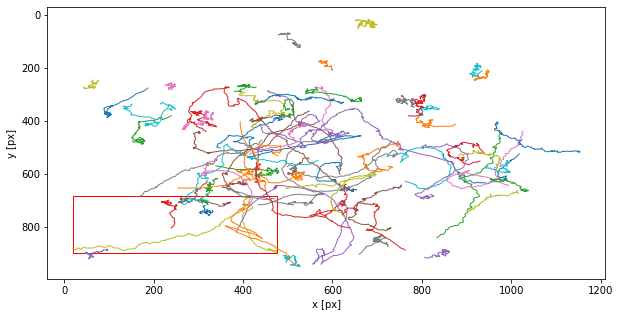

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [107]:
#без нормировки!
def get_l(t2):
    x = min(t2['x'])
    y = min(t2['y'])
    dx = max(t2['x']) - min(t2['x'])
    dy = max(t2['y']) - min(t2['y'])
    return (dx*dx + dy*dy)**0.5

max_dist = 20
t = tp.link(new_f, max_dist, memory=mem)
filt_len = 100
t1 = tp.filter_stubs(t, filt_len)

print("trj longer then "+str(filt_len))
print(t1['particle'].nunique())

max_i = 0
maxl = 0
for i in t1['particle'].unique():
    if get_l(t1[t1['particle'] == i]) > maxl:
        max_i = i
        maxl = get_l(t1[t1['particle'] == i])

t2 = t1[t1['particle'] == max_i]
x = min(t2['x'])
y = min(t2['y'])
dx = max(t2['x']) - min(t2['x'])
dy = max(t2['y']) - min(t2['y'])
print((dx*dx + dy*dy)**0.5)

fig, ax = plt.subplots()
rect = patches.Rectangle((x, y), dx, dy, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

tp.plot_traj(t1);
plt.figure()

trj longer then 100
73


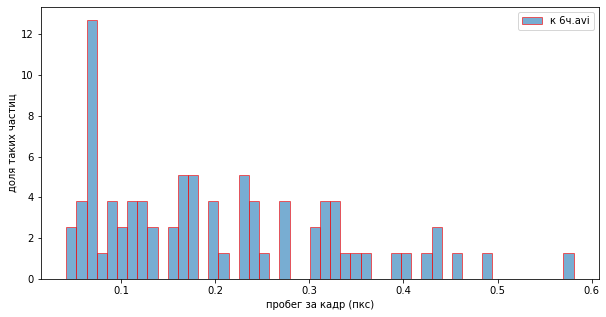

In [108]:
#Нормировка н аколичество кадров!
def get_l(t2):
    x = min(t2['x'])
    y = min(t2['y'])
    dx = max(t2['x']) - min(t2['x'])
    dy = max(t2['y']) - min(t2['y'])
    return (dx*dx + dy*dy)**0.5

filt_len = 100
t1 = tp.filter_stubs(t, filt_len)

print("trj longer then "+str(filt_len))
print(t1['particle'].nunique())

stat = []
N = len(frames)
for i in t1['particle'].unique():
    stat.append(get_l(t1[t1['particle'] == i]) / N)


# рисуем гистограмму
hist_data = plt.hist(stat, bins=50, label=file_name, alpha=0.6, edgecolor='red', density = True)
plt.legend()
plt.xlabel('пробег за кадр (пкс)')
plt.ylabel('доля таких частиц')
plt.show()

# данные из гистограммы https://ru.stackoverflow.com/questions/1348754/%D0%9A%D0%B0%D0%BA-%D0%BF%D0%BE%D0%BB%D1%83%D1%87%D0%B8%D1%82%D1%8C-%D0%BF%D1%80%D0%BE%D0%BC%D0%B5%D0%B6%D1%83%D1%82%D0%BA%D0%B8-plt-hist

In [109]:
print(title, mass_level, max_dist, filt_len)
print("вероятности второй половины распределения",np.sum(hist_data[0][25:] *np.diff(hist_data[1][25:])) )

critical_l = 0.25
for i in range(len(hist_data[1])):
    if hist_data[1][i] > critical_l:
        break

print("вероятность убегания более чем на",critical_l, "равна", np.sum(hist_data[0][i:] *np.diff(hist_data[1][i:])) )

print("Общая вероятность", np.sum(hist_data[0] *np.diff(hist_data[1])) )

к 6ч.avi 200 20 100
вероятности второй половины распределения 0.2328767123287671
вероятность убегания более чем на 0.25 равна 0.3013698630136986
Общая вероятность 0.9999999999999999


# *Сохранение/загрузка из файла (добавить сохранение)

In [163]:
#Сохранение
print('введите название для папки с рассчетом траекторий')
sucsess = False
while not sucsess:
    # Создаем директорию
    sucsess = True
    try:
        title_calc = input()
        os.makedirs(directory + '\\' + title_calc)
    except FileExistsError:
        print('Директория уже существует')
        sucsess = False

# Создаем файл и записываем в него параметры и лог
with open(directory + '\\' + title_calc + '\log.txt', 'w', encoding='utf-8') as f:
    f.write('inv '+ str(inv) + '\n')
    f.write('th ' + str(th) + '\n')
    f.write('mass_level '+ str(mass_level) + '\n')
    f.write('mem ' + str(mem) + '\n')
    f.write('max_dist ' + str(max_dist) + '\n')
    f.write('diam ' + str(diam) + '\n')
    f.write('filt_len ' + str(filt_len) + '\n')
    f.write('base_n ' + str(base_n) + '\n')
    f.write('threshold_bc ' + str(threshold_bc) + '\n')
    f.write('inv' + str(inv) + '\n' + '\n')

t.to_csv(directory + '\\' + title_calc + '\\' + title + '.trj')
stat.to_csv(directory + '\\' + title_calc + '\\' + title + '.hst')

введите название для папки с рассчетом траекторий
zef


In [83]:
# Создаем пустые списки с данными по гистограммам
files = []
# Добавляем файлы в список
directory = "C:\Synology\Alex\dev\\trackCalc\sample_data\\alive"
files += os.listdir(directory)
 
# Выводим список файлов
print('введите номер папки с данными (нумерация с нуля)')
for i in range(len(files)):
    print(i, files[i])
folder_name = files[int(input())]

data_directory = directory +'\\' + folder_name
files = []
files += os.listdir(data_directory)
print(data_directory)
print(files)

for name in files:
    if name.split('.')[-1] == 'trj':
        title = name
        t = pd.read_csv(data_directory + '\\'+ name, index_col=0)
    if name.split('.')[-1] == 'hst':
        stat = pd.read_csv(data_directory + '\\'+ name, index_col=0)

введите номер папки с данными (нумерация с нуля)
0 l.mono 25x100-2.avi
1 l.mono 25x100-3.avi
2 l.mono 25x100-4.avi
3 l.mono 25x100-5.avi
4 l.mono 25x100.avi
5 l.mono 25x40-2.avi
6 l.mono 25x40-3.avi
7 l.mono 25x40.avi
8 test3
8
C:\Synology\Alex\dev\trackCalc\sample_data\alive\test3
['l.mono 25x40.avi.hst', 'l.mono 25x40.avi.trj', 'log.txt']


# *Умная линковка

In [98]:
f = tp.batch(res, diameter = diam, threshold = th, invert=inv, processes=1)


Frame 250: 2569 features


Frame 889: 6 trajectories present.
120


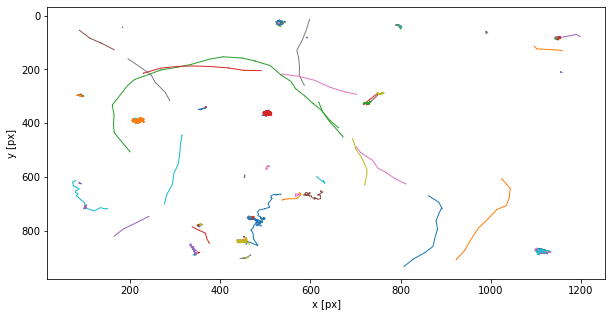

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [202]:
max_dist = 45
new_f = f[f['mass'] > mass_level]

t = tp.link(new_f, max_dist, memory=mem)
filt_len = 15
t1 = tp.filter_stubs(t, filt_len)
print(t1['particle'].nunique())
tp.plot_traj(t1);
plt.figure()

Frame 889: 6 trajectories present.
120


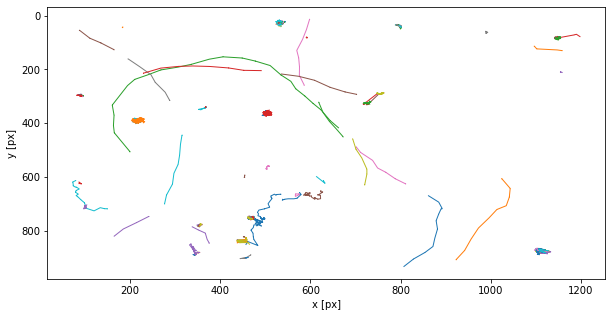

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [200]:
max_dist = 45
new_f = f[f['mass'] > mass_level]

pred = tp.predict.NearestVelocityPredict()
t = pred.link_df(new_f, max_dist)

filt_len = 15
t1 = tp.filter_stubs(t, filt_len)
print(t1['particle'].nunique())
tp.plot_traj(t1);
plt.figure()

# *Анализ траекторий (добавить всякие штуки из трекпай)

In [ ]:
#рисуем траектории
filt_len = 2
t1 = tp.filter_stubs(t, filt_len)
print(t1['particle'].nunique())
tp.plot_traj(t1);
plt.figure()

# *Подбор двух параметров

Frame 889: 6 trajectories present.


ValueError: x and y must have same first dimension, but have shapes (40,) and (6,)

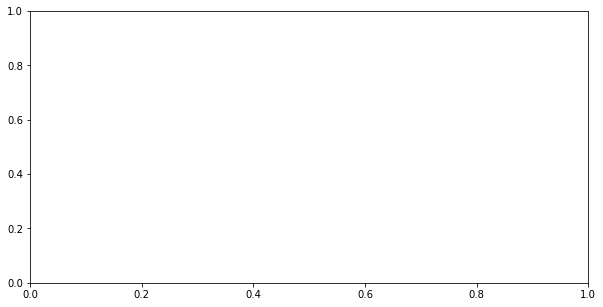

In [191]:
#f = tp.batch(res, diameter = diam, threshold = th, invert=inv, processes=1)

# подбор дистанции
temp = []
x_mass = []
y_dist = []
y_aver_len = []
y_n_uniq = []
for mass_level in range(1,400,10):
    x_mass.append(mass_level)
    for max_dist in range(5,100,5):
        try:
            new_f = f[f['mass'] > mass_level]
            t = tp.link(new_f, max_dist, memory=mem)

            #рисуем траектории
            filt_len = 2
            t1 = tp.filter_stubs(t, filt_len)
            last_d = max_dist
            data = t1.apply(lambda x: x.value_counts().to_dict())['particle'].values()
            n_uniq = t1['particle'].nunique()
            aver_len = sum(data)/n_uniq
            temp.append("mass = " + str(mass_level) + ", dist = " + str(max_dist) + ", uniq_trj = " + str(t1['particle'].nunique()) + ", avr = " + str(aver_len))
        except:
            temp.append("mass = " + str(mass_level) + ", dist = " + str(max_dist) + " ERROR")
            y_dist.append(max_dist)
            y_n_uniq.append(n_uniq)
            y_aver_len.append(aver_len)
            break

        

plt.plot(x_mass, y_dist, 'o-r', label = file_name, alpha=0.7, lw=5, mec='b', mew=2, ms=10)
#plt.plot(x_mass, y_dist, 'o-r', label = file_name, alpha=0.7, lw=5, mec='b', mew=2, ms=10)
plt.legend()
plt.ylabel('max_dist')
plt.xlabel('mass')
plt.grid(True)

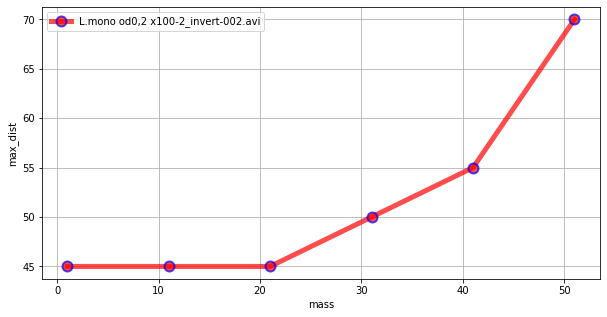

In [198]:
plt.plot(x_mass[0:6], y_dist, 'o-r', label = file_name, alpha=0.7, lw=5, mec='b', mew=2, ms=10)
#plt.plot(x_mass[1:], y_n_uniq[1:], 'o-r', label = file_name, alpha=0.7, lw=5, mec='b', mew=2, ms=10)
#plt.plot(x_mass, y_aver_len, 'o-r', label = file_name, alpha=0.7, lw=5, mec='b', mew=2, ms=10)
plt.legend()
plt.ylabel('max_dist')
plt.xlabel('mass')
plt.grid(True)

# Какой то код - хз, что

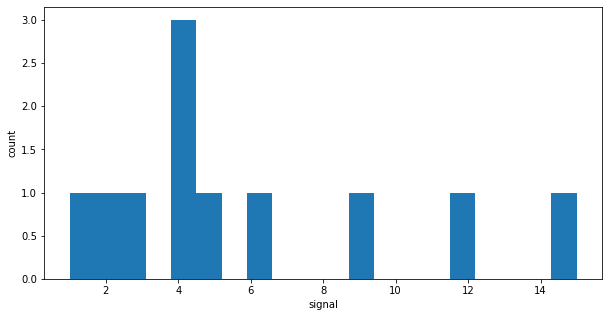

In [116]:
# ненужный код - но максимально быстро напоминает, как строить гистограммы

d = [1,2,3,4,4,4,5,6,9,12,15]
fig, ax = plt.subplots()
ax.hist(d, bins=20)
ax.set(xlabel='signal', ylabel='count');

In [ ]:
#создание папки ,куда будем сохранять файлы траекторий
print('введите название для папки с рассчетом траекторий')
sucsess = False
while not sucsess:
    # Создаем директорию
    sucsess = True
    try:
        title_calc = input()
        os.makedirs(directory + '\\' + title_calc)
    except FileExistsError:
        print('Директория уже существует')
        sucsess = False

In [ ]:
# подбор двух параметров и визуализация результата. В качестве метрики - количество траекторий
# чем больше траекторий - тем более белой будет точка!

a1 = 50
a2 = 1000
a_title = 'mass'
da = 500

b1 = 3
b2 = 150
b_title = 'dist'
db = 100


trj_lens = np.zeros(((a2 - a1)//da+1,(b2 - b1)//db+1), dtype="int")


In [ ]:
inv = False
th = 2
mass_level = 100
mem = 1
max_dist = 20
diam = 29



pr_bar = IntProgress(min=0, max=((a2 - a1)//da) * ((b2 - b1)//db))
display(pr_bar)

for mass_level in range(a1,a2,da):
    a = mass_level
    for max_dist in range(b1,b2,db):
        b = max_dist
        pr_bar.value += 1
        print(mass_level, (mass_level - a1)//da, max_dist, (max_dist - b1)//db)
        try:
            f = tp.batch(res, diameter = diam, threshold = th, invert=inv, processes=1)
            new_f = f[f['mass'] > mass_level]
            t = tp.link(new_f, max_dist, memory=mem)
            t.to_csv(directory + '\\' + title_calc + '\\' + (file_name+'_'+a_title+str(a)+'_'+file_name+'_'+b_title+str(b)) + '.trj')
            t1 = tp.filter_stubs(t, filt_len)
            trj_lens[(a - a1)//da][(b - b1)//db] = t1['particle'].nunique()
        except:
            trj_lens[(a - a1)//da][(b - b1)//db] = 0

In [ ]:
fig, ax = plt.subplots()
ax.imshow(trj_lens)
ax.set_ylabel(a_title+' '+str(a1)+':'+str(a2)+'(+'+str(da)+')', color='red')
ax.set_xlabel(b_title+' '+str(b1)+':'+str(b2)+'(+'+str(db)+')', color='red')

ax.set_title('Подбор 2х параметров')
plt.show()

# TODO

0. сделать вывод параметров рядом с кружками у бактерий.
1. сделать циклом подбор длины дистанции и памяти. через try. В качестве критерия - количество уникальных треков. Сделать это хотя бы для двух - трех различных масс.
2. Скорее всего там будет два параметра которые нельзя максимизировать одновременно. Для них запустить визуализацию на поле.
3. прочитать, как работает линковка. Учитываются ли дополнительные параметры частиц?
5. почитать про светящиеся кольца - можно ли определять так бактерии

# Заметки

заметки 2025

валидировать вычитание фона и сами частички. Что там с кодом Олега. Фон вычитается так же? Нет никаких колец и прочего? Сделать подбор массы по характерному количеству, которе ждем на кадре. Спросить как точно мы можем это определить?

**Гипотеза, которую проверял: Пробег частицы в рамках одной траектории зависит от концентрации. Чем концентрация выше - тем меньше пробег. Потому что треки рвутся при самопересечении. Но при уменьшении концентрации пробег увеличивается не бесконечно, а до "истинного" или максимального при этой длительности**

выбирать массу исходя из предпологаемго количества бактерий - спросить - как точно мы можем это определять?

Сделать рассчет точек с помощью плазмы и затем раклькуляцию при помощи питона

Сделать визуализацию того, что считает трек пай при при помощи плазмы!!!

### первоочередное

поиск бактерий

* Размытые бактреии - через подбор массы. Это ок?

* что с длинными бактериями? они отличаются? Они трекаются? пример на видосах Даши

* 'Salm 37 + Tag-7 _2' - тут не точки, а полукруги вместо бактерий. может искать не через свечение, а через полукруги? Там есть в библиотеки такая функция

* поработать с видео на увеличении 100. Там совсем бругие бактерии

линковка и получение длинных треков

* почитать - влияют ли параметры бактерий (масса, ecc, размер и тд) на линковку? Если да, то как? если нет - то придется писать свою функцию линковки

* посмотреть, что такое адаптивный поиск, может сделать https://soft-matter.github.io/trackpy/dev/tutorial/adaptive-search.html

* сделать нормалные ед.изм., а не попугаи. Уже в финальном отображении. То есть не "пиксели/кадр", а значения скоростей в "мкм/с"

* **сделать визуальный автоподбор дистанции и памяти(Salm 37 _2.avi)**
* В линковке mem работает так, как я думаю?
* Как параметр mem влияет на треки при плохо подобранной дистанции и при хорошо подобранной дистанции?


Общие вопросы на подумать - могут дать идеи новые

* **проработать первые видосы, где мало бактерий. Моежет теперь получится получить длинные треки, когда есть вычитание фона?**

* сальманелы - там прям два типа бактерий - быстрые и медленные. (например Salm 24 + Tag-7 _1) (Salm 37 _3.avi) и должно быть два пика. но нихрена. почему?


* должны быть бактерии, которыепробегаютбольшое расстояние (P.a 1840 К 4,5Ч.avi, L.mono od0,2 x100-2_invert-002.avi)


Важные будущие задачи
* **Пройти все тоуторилы от трекпай. Не прочитать, а прям пройти**

* сделать процесс линковки самостоятельно...

* **проверить видосы Даши**

* **сделать так, чтобы длинные треки вносили более значительное влияние на скорости**




### какие мне нужны видео!

нужен видос с живыми, нормальными бактериями, где их мало! отдельно для каждого вида. Потому что такие видосы иделаьны для подбора дистанции. Чтобы там прм быстро бегали!

Нужна серия видосов по увеличению количества бактерий

Нужен видос с сеткой для определения размера

### второстепенное

разобратся с ошибкой - почему не строит дрейф. у некоторых видосов. последовательность стрелок

сделать сглаживание дрейфа - убрать ежик

сделать анализ и подсчет неподвижных - на фоне

И посомтреть глазами - что там происходит с бактериями.Как обрабатываются пересечения

### заметки и ссылки

Про поиск фич:
1. поиск больших штук, ткаих как пузырьки. Которые контактируют друг с другом. Не уверен, что надо, н олучше прочитать. Как миниму - там считают скорости и рисуют траектории. Это может быть просто более удобно. https://soft-matter.github.io/trackpy/dev/tutorial/custom-feature-detection.html
2. поиск колец. Точно надо почитать, оптому что у меня именно кольца после вычитания фона. https://soft-matter.github.io/trackpy/dev/tutorial/brightfield.html

Про линковку
1. линковка с ипользованием предсказания скоростей. Обязательно попробовать! https://soft-matter.github.io/trackpy/dev/tutorial/prediction.html
2. что такое подсети по которым осуществляется поиск. https://soft-matter.github.io/trackpy/dev/tutorial/subnets.html
3. адаптивный поиск. понятно, что это на уровне идеи, но непонятна реализация https://soft-matter.github.io/trackpy/dev/tutorial/adaptive-search.html

анализ гистограмм - нормаировка, критерии https://habr.com/ru/companies/skillfactory/articles/674880/

про критерий колмагорова https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D1%81%D0%BE%D0%B3%D0%BB%D0%B0%D1%81%D0%B8%D1%8F_%D0%9A%D0%BE%D0%BB%D0%BC%D0%BE%D0%B3%D0%BE%D1%80%D0%BE%D0%B2%D0%B0


### то, что "сделал"

* **посчитать колмаг.смирнова на видео от Марьям и посмотреть глазами и сравить с тем, что получилось** - стало понятно, что критерий применять плохо, да и гистограмки, кажется, не сильно информативны. Причина в том, что они считают неправильно. Это связано с проблемой линковки. Надо поправить линковку и все станет хорошо. Хотя гистограмма не факт, чт обудет прям хорошо кореллировать с подвижностью. А вот длина треков - потенциально очень интересна для классификации.

* Проработал видео с одиночными бактериями и стало понятно, что есть проблема с линковкой. ОЧень большой вопрос - корректно ли это считалось у Лены, кстати. Потому что гистограмки в целом у меня примрено такие же. Но может и корректно, сложно сказать

# К семинару

1. Все плохо со сравнением г-к. Но, наверное, для патента подойдет.
2. Как я понял что все плохо (не работает критерий, глазами разница очевидна, полез смотреть одиночные бактерии). Нужны длинные траектории (причем они должны быть, см. P.a 1840 К 4,5Ч.avi)
3. Как работает прога - какие есть этапы.
4. Разбор примера с одиночными бактериями (Видео L.mono od0,2 x100-2_invert-002.avi). Почему я перестал его смотреть (потому что получил какие то треки, а потом получил гисторгаммы на большом количестве. И работал с гистограммами). Почему надо смотреть (потому что глазами все понятно, непонятно, как Лена валидировала прошлую прогу без этого)
5. масса - как подбирать и надо ли опдбирать вообще? (я по инерции продолжаю баловатся с этим параметром, но может после вычитания фона уже и не надо?) **сказать про поиск светящихся колец и про поиск длинных бактерий**
6. дистанция - как подбирать. Проблема максимальной скорости и склеивания соседних частиц. что с видосом с гистомецином при нормальной дистанции?
7. память - как подбирать. **Надо ли? На что влияет?**
8. Как можно поправить линковку? **как работает стандартная**
9. Планы. (работа над линковкой, работа над трекингом отдельных бактерий)
10. Какие видосы мне нужны

показать анимацию

*спросить про учебник
________________

1. Серия видео с изменением концентрации
2. Всевозможные условия съемки (бактерии, различные увеличения) - только живые, подвижные бактерии. Какие вообще есть параметры у эксперимента, от которых зависит картинка? Надо для однозначной классификации типов картинки
3. треккер задач
________________
1. Исследовать параметр dist - понять какой dist нужен для текущих условий (исследовать для этого какой-нибудь кадр с быстрой бактерией)
2. взаимосвязь signal и mass (сделать исследование взаимосвязи двух произвольных параметров, например ecc и mass). - надо чтобы точно понять по какому из параметров фильтровать. На примере видоса 350частиц
3. Посмотреть, как меняется максимальная дистанция линковки при изменении концентрации. Должно быть: чем меньше концентрация - тем больше предельная дистанция вплоть до нужной.
4. Проверить - меняется ли "средний размах" траектории у живых и мертвых бактерий? Можно сравнивать эти два параметра независимо от предыдущих экспериментов.
____________
1. сделать свою линковку, чтобы бактерии не исчезали при пересечении траекторий
2. Еще раз прочитать гайд и разобратся - что за методы они применяют для оценки "правдаподобия" траекторий?
